# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [25]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import math
import matplotlib.pyplot as plt

plt_interval = 50

transform = transforms.Compose(
   [transforms.ToTensor()])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 1; label2 = 7 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# Grayscale and vectorize images
trainset.train_data  = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in trainset.train_data])
train_data = np.asarray([img.flatten() for img in trainset.train_data])
train_labels = trainset.train_labels
testset.test_data  = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testset.test_data])
test_data = np.asarray([img.flatten() for img in testset.test_data])
test_labels = testset.test_labels
print("Dimensions of grayscaled vectorized images:", np.shape(train_data))

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Dimensions of grayscaled vectorized images: (20000, 1024)
Data loaded:
- Training set size: 20000
- Test set size: 2000


Test Images:


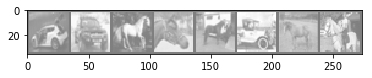

truck truck   car   car   car truck   car   car
Train Images:


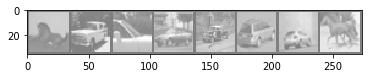

  car truck truck truck truck truck truck   car


In [26]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Online Weak Learner: Perceptron

In [55]:
# parameters
eta = 0.01
step = 500

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

In [56]:
def baseline(weak_learner, T):
    n_mistakes = 0    
    n_mistakes_over_time = []
    accuracy = []
    
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
            
        # test on the fly
        if t % step == 0:
            correct = 0
            for data in testloader:
                x, y = data
                x = x.numpy().flatten()
                prediction = predict_WL([weak_learner], x, 0)
                correct += (prediction == y).sum().item()
            acc = 100 * correct / len(testloader)
            accuracy.append(acc)   
            
            # output performance
            print('Accuracy of weak learner after %d iterations on the 2000 test images: %d %%' % (t, acc))    
            print("Fraction of mistakes after %d iterations:" % t, n_mistakes / t) 
    
    return accuracy

# Online BBM 

In [68]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T, gamma):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    accuracy = []
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)
        n_mistakes += (y_hat != y).item()
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
            
        # test on the fly
        if t % step == 0:
            correct = 0
            for data in testloader:
                x, y = data
                x = x.numpy().flatten()
                prediction = predict_WL_alg1(weak_learners, x)
                correct += (prediction == y).sum().item()
            acc = 100 * correct / len(testloader)
            accuracy.append(acc)  

            # output performance
            print('Accuracy of weak learner after %d iterations on the 2000 test images: %d %%' % (t, acc))    
            print("Fraction of mistakes after %d iterations:" % t, n_mistakes / t) 

                
    return accuracy

# AdaBoost OL

In [69]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    accuracy = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        n_mistakes += (y_hat_final != y).item()
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            eta_t = 4 / np.sqrt(t)
            alpha[j-1] = max(-2, min(2, alpha[j-1] + eta_t * z[j] / (1 + math.exp(s[j]))))
            
            # pass training example to WL j with some probability
            w = 1 / (1 + math.exp(s[j-1]))
            if np.random.random_sample() < w:
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * math.exp(indic)
            
        # test on the fly
        if t % step == 0:
            correct = 0
            for data in testloader:
                x, y = data
                x = x.numpy().flatten()
                prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
                correct += (prediction == y).sum().item()
            acc = 100 * correct / len(testloader)
            accuracy.append(acc)  
            
            # output performance
            print('Accuracy of weak learner after %d iterations on the 2000 test images: %d %%' % (t, acc))    
            print("Fraction of mistakes after %d iterations:" % t, n_mistakes / t) 
    
    return accuracy   
    

# Batch AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost(T):
    accuracy = []
    for i in range(step, T+1, step):
        # AdaBoost with decision trees for weak learners
        booster = AdaBoostClassifier(n_estimators=50, learning_rate=1)
        print("Training on %d examples..." % i)
        ret = booster.fit(train_data[:i], train_labels[:i])

        print("Testing...")
        y_hat = booster.predict(test_data)
        acc = sum(y_hat==test_labels) / len(test_labels)
        accuracy.append(100*acc)
        print("Accuracy on %d test examples:" % len(test_labels))
        print(acc)
    return accuracy

## Evaluate Models

In [64]:
base_acc = baseline(np.zeros(1024), 10000)
print(base_acc)

Accuracy of weak learner after 500 iterations on the 2000 test images: 63 %
Fraction of mistakes after 500 iterations: 0.402
Accuracy of weak learner after 1000 iterations on the 2000 test images: 54 %
Fraction of mistakes after 1000 iterations: 0.41
Accuracy of weak learner after 1500 iterations on the 2000 test images: 51 %
Fraction of mistakes after 1500 iterations: 0.3873333333333333
Accuracy of weak learner after 2000 iterations on the 2000 test images: 70 %
Fraction of mistakes after 2000 iterations: 0.3695
Accuracy of weak learner after 2500 iterations on the 2000 test images: 50 %
Fraction of mistakes after 2500 iterations: 0.3624
Accuracy of weak learner after 3000 iterations on the 2000 test images: 75 %
Fraction of mistakes after 3000 iterations: 0.35533333333333333
Accuracy of weak learner after 3500 iterations on the 2000 test images: 51 %
Fraction of mistakes after 3500 iterations: 0.3522857142857143
Accuracy of weak learner after 4000 iterations on the 2000 test images: 

In [70]:
N = 4
weak_learners = [np.zeros(1024) for i in range(N)]
adol_acc = adaboostOL(weak_learners, 10000)
print(adol_acc)

Accuracy of weak learner after 500 iterations on the 2000 test images: 73 %
Fraction of mistakes after 500 iterations: 0.474
Accuracy of weak learner after 1000 iterations on the 2000 test images: 75 %
Fraction of mistakes after 1000 iterations: 0.42
Accuracy of weak learner after 1500 iterations on the 2000 test images: 76 %
Fraction of mistakes after 1500 iterations: 0.4026666666666667
Accuracy of weak learner after 2000 iterations on the 2000 test images: 74 %
Fraction of mistakes after 2000 iterations: 0.3755
Accuracy of weak learner after 2500 iterations on the 2000 test images: 71 %
Fraction of mistakes after 2500 iterations: 0.3764
Accuracy of weak learner after 3000 iterations on the 2000 test images: 58 %
Fraction of mistakes after 3000 iterations: 0.37
Accuracy of weak learner after 3500 iterations on the 2000 test images: 72 %
Fraction of mistakes after 3500 iterations: 0.364
Accuracy of weak learner after 4000 iterations on the 2000 test images: 73 %
Fraction of mistakes af

In [71]:
N = 4
weak_learners = [np.zeros(1024) for i in range(N)]
bbm_acc = onlineBBM(weak_learners, 10000, 0.15)
print(bbm_acc)

Accuracy of weak learner after 500 iterations on the 2000 test images: 71 %
Fraction of mistakes after 500 iterations: 0.378
Accuracy of weak learner after 1000 iterations on the 2000 test images: 72 %
Fraction of mistakes after 1000 iterations: 0.369
Accuracy of weak learner after 1500 iterations on the 2000 test images: 75 %
Fraction of mistakes after 1500 iterations: 0.3546666666666667
Accuracy of weak learner after 2000 iterations on the 2000 test images: 76 %
Fraction of mistakes after 2000 iterations: 0.337
Accuracy of weak learner after 2500 iterations on the 2000 test images: 75 %
Fraction of mistakes after 2500 iterations: 0.3244
Accuracy of weak learner after 3000 iterations on the 2000 test images: 67 %
Fraction of mistakes after 3000 iterations: 0.31533333333333335
Accuracy of weak learner after 3500 iterations on the 2000 test images: 70 %
Fraction of mistakes after 3500 iterations: 0.31057142857142855
Accuracy of weak learner after 4000 iterations on the 2000 test images:

In [ ]:
ad_acc = adaboost(10000)
print(ad_acc)

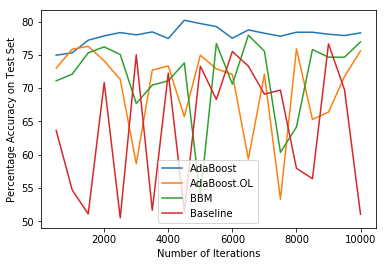

In [73]:
# plot accuracy over number of samples
iterations = np.arange(step, 10001, step)
plt.plot(iterations, ad_acc)
plt.plot(iterations, adol_acc)
plt.plot(iterations, bbm_acc)
plt.plot(iterations, base_acc)
plt.xlabel("Number of Iterations")
plt.ylabel("Percentage Accuracy on Test Set")
plt.legend(['AdaBoost', 'AdaBoost.OL', 'BBM', 'Baseline'])
plt.show()

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf

AdaBoost algorithm implementation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html 